# EIP7691 Safety Analysis
This notebook is used to analyze the safety of the EIP7691 activation on the network of choice.

It will connect to a beacon node, query for the fork activation and then run the analysis for around the fork activation time.

See .env.example to set the environment variables.

In [1]:
!pip install jupysql clickhouse_sqlalchemy matplotlib python-dotenv pandas seaborn imageio > /dev/null 2>&1

In [2]:
import dotenv
import os
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import imageio

dotenv.load_dotenv()

beacon_node_url = os.getenv('BEACON_NODE_URL')
if not beacon_node_url:
    raise ValueError("BEACON_NODE_URL environment variable is required")


params = {
    "network": "pectra-devnet-5",
    "fork": 'electra',
    "before_hours": 0,
    "after_hours": 24
}

fork_name = params["fork"]
network = params["network"]
before_hours = params["before_hours"]
after_hours = params["after_hours"]

print(f"network: {network}")
print(f"fork_name: {fork_name}")
print(f"analysis_before_fork_hours: {before_hours}")
print(f"analysis_after_fork_hours: {after_hours}")


/Users/samcm/.pyenv/versions/anaconda3-2022.05/envs/ldm/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


network: pectra-devnet-5
fork_name: electra
analysis_before_fork_hours: 0
analysis_after_fork_hours: 24


In [3]:
def add_branding(fig, title=None, subtitle=None):
    # Get dimensions of input figure
    fig_width = fig.get_size_inches()[0]
    
    # Create header figure with fixed height (reduced to 25%)
    header_height = 1 # Was 2
    header_fig = plt.figure(figsize=(fig_width, header_height))
    
    # Add logos with increased size
    left_logo_ax = header_fig.add_axes([0.02, 0.2, 0.18, 0.7])  # Increased width and height
    right_logo_ax = header_fig.add_axes([0.82, 0.2, 0.16, 0.7]) # Increased width and height
    
    ethpandaops = plt.imread('../../../assets/content/ethpandaops.png')
    xatu = plt.imread('../../../assets/content/xatu.png')
    
    left_logo_ax.imshow(ethpandaops)
    right_logo_ax.imshow(xatu)
    
    left_logo_ax.axis('off')
    right_logo_ax.axis('off')
    
    # Add title and subtitle if provided
    if title:
        header_fig.text(0.5, 0.7, title, fontsize=20, fontweight='bold', ha='center')
    if subtitle:
        header_fig.text(0.5, 0.4, subtitle, fontsize=12, ha='center')
        
    # Stack figures
    combined_height = header_height + fig.get_size_inches()[1]
    combined_fig = plt.figure(figsize=(fig_width, combined_height))
    
    # Draw figures before accessing canvas
    header_fig.canvas.draw()
    fig.canvas.draw()
    
    # Copy contents using buffer_rgba instead of deprecated tostring_rgb
    header_img = np.frombuffer(header_fig.canvas.buffer_rgba(), dtype=np.uint8)
    header_img = header_img.reshape(header_fig.canvas.get_width_height()[::-1] + (4,))[:,:,:3]
    
    fig_img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    fig_img = fig_img.reshape(fig.canvas.get_width_height()[::-1] + (4,))[:,:,:3]
    
    # Add to combined figure
    header_ax = combined_fig.add_axes([0, fig.get_size_inches()[1]/combined_height, 1, header_height/combined_height])
    content_ax = combined_fig.add_axes([0, 0, 1, fig.get_size_inches()[1]/combined_height])
    
    header_ax.imshow(header_img)
    content_ax.imshow(fig_img)
    
    header_ax.axis('off')
    content_ax.axis('off')
    
    plt.close(header_fig)
    plt.close(fig)
    
    return combined_fig

In [4]:
# Connect to ClickHouse
import os
username = os.getenv('XATU_CLICKHOUSE_USERNAME')
password = os.getenv('XATU_CLICKHOUSE_PASSWORD')
host = os.getenv('XATU_CLICKHOUSE_HOST')


db_url = f"clickhouse+http://{username}:{password}@{host}:443/default?protocol=https"

from sqlalchemy import create_engine, text

engine = create_engine(db_url)

connection = engine.connect()

In [5]:
from requests import get
from datetime import datetime, timezone, timedelta

# Hit the beacon node to get the fork activation time
response = get(f"{beacon_node_url}/eth/v1/config/spec")
fork_activation_epoch = int(response.json()['data'][f'{fork_name.upper()}_FORK_EPOCH'])

genesis = get(f"{beacon_node_url}/eth/v1/beacon/genesis")
genesis_time = int(genesis.json()['data']['genesis_time'])

print(f"Fork activation epoch: {fork_activation_epoch}")
print(f"Genesis time: {genesis_time}")

fork_activation_time = datetime.fromtimestamp(genesis_time, tz=timezone.utc) + timedelta(seconds=fork_activation_epoch * 12 * 32)
print(f"Fork activation time: {fork_activation_time}")

start_date = fork_activation_time - timedelta(hours=int(before_hours))
end_date = fork_activation_time + timedelta(hours=int(after_hours))

print(f"Start date: {start_date}")
print(f"End date: {end_date}")


Fork activation epoch: 4
Genesis time: 1737034260
Fork activation time: 2025-01-16 13:56:36+00:00
Start date: 2025-01-16 13:56:36+00:00
End date: 2025-01-17 13:56:36+00:00


In [6]:
# Query for all slots in time window
all_slots_query = text("""
    SELECT DISTINCT
        slot,
        slot_start_date_time as time
    FROM beacon_api_eth_v1_events_block FINAL 
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date) AND toDateTime(:end_date)
        AND meta_network_name = :network
    ORDER BY slot ASC
""")

result = connection.execute(all_slots_query, {
    "start_date": start_date.strftime("%Y-%m-%d %H:%M:%S"),
    "end_date": end_date.strftime("%Y-%m-%d %H:%M:%S"), 
    "network": network
})
all_slots = pd.DataFrame(result.fetchall(), columns=['slot', 'time'])


In [7]:
# Query to get block sizes for all slots
print("Getting block sizes...")
block_sizes_query = text("""
    SELECT 
        slot,
        block_total_bytes_compressed,
        slot_start_date_time as time,
        proposer_index,
        block_root
    FROM canonical_beacon_block FINAL
    WHERE 
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_network_name = :network
""")
block_sizes = pd.DataFrame(
    connection.execute(block_sizes_query, {
        "start_date": start_date.strftime("%Y-%m-%d %H:%M:%S"),
        "end_date": end_date.strftime("%Y-%m-%d %H:%M:%S"), 
        "network": network
    }).fetchall(),
    columns=['slot', 'block_total_bytes_compressed', 'time', 'proposer_index', 'block_root']
)

print("Getting blob sidecar data...")
# Get blob sidecar data for our slots
blob_sidecars_query = text("""
    SELECT 
        slot,
        COUNT(*) as num_blobs,
        SUM(blob_size) as total_blob_size
    FROM canonical_beacon_blob_sidecar FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_network_name = :network
    GROUP BY slot, toDate(slot_start_date_time)
""")
blob_sidecars = pd.DataFrame(
    connection.execute(blob_sidecars_query, {
        "start_date": start_date.strftime("%Y-%m-%d %H:%M:%S"),
        "end_date": end_date.strftime("%Y-%m-%d %H:%M:%S"), 
        "network": network
    }).fetchall(),
    columns=['slot', 'num_blobs', 'total_blob_size']
)

print("Getting first seen in p2p data...")
first_seen_in_p2p_query = text("""
    SELECT
        slot,
        block as block_root,
        MIN(propagation_slot_start_diff) as first_seen_in_p2p
    FROM libp2p_gossipsub_beacon_block FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_network_name = :network
    GROUP BY slot, block
""")
first_seen_in_p2p = pd.DataFrame(
    connection.execute(first_seen_in_p2p_query, {
        "start_date": start_date.strftime("%Y-%m-%d %H:%M:%S"),
        "end_date": end_date.strftime("%Y-%m-%d %H:%M:%S"), 
        "network": network
    }).fetchall(),
    columns=['slot', 'block_root', 'first_seen_in_p2p']
)

print("Getting first seen attestation for block in p2p data...")
first_seen_attestation_in_p2p_query = text("""
    SELECT
        slot,
        beacon_block_root as block_root,
        MIN(propagation_slot_start_diff) as first_seen_attestation_in_p2p
    FROM libp2p_gossipsub_beacon_attestation FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_network_name = :network
    GROUP BY slot, beacon_block_root
""")
first_seen_attestation_in_p2p = pd.DataFrame(
    connection.execute(first_seen_attestation_in_p2p_query, {
        "start_date": start_date.strftime("%Y-%m-%d %H:%M:%S"),
        "end_date": end_date.strftime("%Y-%m-%d %H:%M:%S"), 
        "network": network
    }).fetchall(),
    columns=['slot', 'block_root', 'first_seen_attestation_in_p2p']
)

print("Getting arrival times...")
aggregated_arrival_times_query = text("""
    WITH arrival_times AS (
        SELECT
            slot,
            slot_start_date_time,
            meta_client_name,
            propagation_slot_start_diff
        FROM beacon_api_eth_v1_events_head FINAL
        WHERE
            slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
            AND meta_client_name != ''
            AND meta_client_name IS NOT NULL
            AND meta_network_name = :network
            AND propagation_slot_start_diff < 6000
    )
    SELECT
        slot,
        CASE
            WHEN position('/' IN meta_client_name) = 0 THEN 'ethpandaops'
            WHEN meta_client_name NOT LIKE '%ethpandaops%' THEN 'home users'
            ELSE 'ethpandaops'
        END as observed_by_group,
        min(propagation_slot_start_diff) as min_arrival_time,
        quantile(0.50)(propagation_slot_start_diff) as p50_arrival_time,
        quantile(0.90)(propagation_slot_start_diff) as p90_arrival_time,
        quantile(0.99)(propagation_slot_start_diff) as p99_arrival_time
    FROM arrival_times
    GROUP BY 
        slot,
        CASE
            WHEN position('/' IN meta_client_name) = 0 THEN 'ethpandaops'
            WHEN meta_client_name NOT LIKE '%ethpandaops%' THEN 'home users'
            ELSE 'ethpandaops'
        END
    ORDER BY slot
""")

aggregated_arrival_times = pd.DataFrame(
    connection.execute(aggregated_arrival_times_query, {
        "start_date": start_date.strftime("%Y-%m-%d %H:%M:%S"),
        "end_date": end_date.strftime("%Y-%m-%d %H:%M:%S"), 
        "network": network
    }).fetchall(),
    columns=['slot', 'observed_by_group', 'min_arrival_time', 'p50_arrival_time', 'p90_arrival_time', 'p99_arrival_time']
)

# Convert blob_sidecars to a dictionary
blob_sidecars_map = blob_sidecars.set_index('slot').to_dict(orient='index')

# Build combined data using block_sizes as the canonical list of slots
combined_data = block_sizes.copy()
# combined_data = combined_data.merge(first_seen_in_p2p, on=['slot', 'block_root'], how='left')
# combined_data = combined_data.merge(first_seen_attestation_in_p2p, on=['slot', 'block_root'], how='left')
# combined_data = combined_data.merge(arrival_times[['slot', 'min_arrival_time', 'p50_arrival_time', 'p90_arrival_time', 'p99_arrival_time']], on='slot', how='left')
combined_data['num_blobs'] = combined_data['slot'].map(lambda slot: blob_sidecars_map.get(slot, {'num_blobs': 0})['num_blobs'])
combined_data['total_blob_size'] = combined_data['slot'].map(lambda slot: blob_sidecars_map.get(slot, {'total_blob_size': 0})['total_blob_size'])

# Calculate total data per slot
combined_data['total_data_per_slot'] = combined_data['block_total_bytes_compressed'] + combined_data['total_blob_size']
combined_data['total_size_mb'] = (combined_data['block_total_bytes_compressed'] + combined_data['total_blob_size']) / 1_000_000  


combined_data['block_pct'] = combined_data['block_total_bytes_compressed'] / combined_data['total_data_per_slot'] * 100
combined_data['blob_pct'] = combined_data['total_blob_size'] / combined_data['total_data_per_slot'] * 100

# Add 'via_mev' column to combined_data
combined_data['date'] = pd.to_datetime(combined_data['time']).dt.date


Getting block sizes...
Getting blob sidecar data...
Getting first seen in p2p data...
Getting first seen attestation for block in p2p data...
Getting arrival times...


In [8]:
# Get head arrival times per client
print("Getting head arrival times...")
head_arrival_query = text("""
    SELECT 
        slot,
        MIN(propagation_slot_start_diff) as head_arrival_time,
        meta_client_name
    FROM beacon_api_eth_v1_events_head FINAL
    WHERE 
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_network_name = :network
    GROUP BY slot, meta_client_name
""")
head_arrival_times = pd.DataFrame(
    connection.execute(head_arrival_query, {
        "start_date": start_date.strftime("%Y-%m-%d %H:%M:%S"),
        "end_date": end_date.strftime("%Y-%m-%d %H:%M:%S"), 
        "network": network
    }).fetchall(),
    columns=['slot', 'head_arrival_time', 'meta_client_name']
)


Getting head arrival times...


In [9]:
# Get block arrival times per client
print("Getting block arrival times...")
block_arrival_query = text("""
    SELECT 
        slot,
        MIN(propagation_slot_start_diff) as block_arrival_time,
        meta_client_name
    FROM beacon_api_eth_v1_events_block FINAL
    WHERE 
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_network_name = :network
    GROUP BY slot, meta_client_name
""")
block_arrival_times = pd.DataFrame(
    connection.execute(block_arrival_query, {
        "start_date": start_date.strftime("%Y-%m-%d %H:%M:%S"),
        "end_date": end_date.strftime("%Y-%m-%d %H:%M:%S"), 
        "network": network
    }).fetchall(),
    columns=['slot', 'block_arrival_time', 'meta_client_name']
)


Getting block arrival times...


In [10]:
# Get blob arrival times per client
print("Getting blob arrival times...")
blob_arrival_query = text("""
    SELECT
        slot,
        MAX(propagation_slot_start_diff) as last_blob_arrival_time,
        meta_client_name
    FROM beacon_api_eth_v1_events_blob_sidecar FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC') 
        AND meta_network_name = :network
    GROUP BY slot, meta_client_name
""")
blob_arrival_times = pd.DataFrame(
    connection.execute(blob_arrival_query, {
        "start_date": start_date.strftime("%Y-%m-%d %H:%M:%S"),
        "end_date": end_date.strftime("%Y-%m-%d %H:%M:%S"), 
        "network": network
    }).fetchall(),
    columns=['slot', 'last_blob_arrival_time', 'meta_client_name']
)


Getting blob arrival times...


In [11]:
# Merge all arrival times into one dataframe
raw_arrival_data = pd.merge(head_arrival_times, block_arrival_times, on=['slot', 'meta_client_name'], how='outer')
raw_arrival_data = pd.merge(raw_arrival_data, blob_arrival_times, on=['slot', 'meta_client_name'], how='outer')

# Get the latest arrival time between head/block/blob for each client/slot
# Handle missing columns by using fillna
raw_arrival_data['arrival_time'] = raw_arrival_data[[
    'head_arrival_time', 
    'block_arrival_time', 
    'last_blob_arrival_time'
]].fillna(-float('inf')).max(axis=1)

print(raw_arrival_data)

       slot  head_arrival_time                   meta_client_name  \
0      6085              414.0  pectra-devnet-5-lighthouse-geth-2   
1      6085              509.0  pectra-devnet-5-lighthouse-geth-5   
2      6085              411.0       pectra-devnet-5-prysm-reth-1   
3      6085              391.0        pectra-devnet-5-teku-besu-1   
4      6086              429.0  pectra-devnet-5-lighthouse-geth-2   
...     ...                ...                                ...   
38955  7328             3003.0        pectra-devnet-5-teku-geth-3   
38956  7328             3005.0        pectra-devnet-5-teku-geth-4   
38957  7328             3004.0  pectra-devnet-5-teku-nethermind-1   
38958  7328             3004.0        pectra-devnet-5-teku-reth-1   
38959  7328             3003.0        pectra-devnet-5-teku-reth-2   

       block_arrival_time  last_blob_arrival_time  arrival_time  
0                   412.0                   408.0         414.0  
1                   503.0              

In [12]:
# Add country and group info
query = text("""
    SELECT 
        meta_client_name,
        meta_client_geo_country as country,
        CASE
            WHEN position('/' IN meta_client_name) = 0 THEN 'ethpandaops'
            WHEN meta_client_name NOT LIKE '%ethpandaops%' THEN 'home users'
            ELSE 'ethpandaops'
        END as observed_by_group
    FROM beacon_api_eth_v1_events_head FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_client_name != ''
        AND meta_client_name IS NOT NULL
        AND meta_network_name = :network
    GROUP BY meta_client_name, meta_client_geo_country
""")

client_info = pd.DataFrame(
    connection.execute(query, {
        "start_date": start_date.strftime("%Y-%m-%d %H:%M:%S"),
        "end_date": end_date.strftime("%Y-%m-%d %H:%M:%S"), 
        "network": network
    }).fetchall(),
    columns=['meta_client_name', 'country', 'observed_by_group']
)

print("Query done.. merging everything together...")

arrival_data = pd.merge(raw_arrival_data, client_info, on='meta_client_name', how='left')

# Filter out very late arrivals and replace -inf with NaN
# Subtract 100ms to account for the 100ms delay from the event stream processing.
arrival_data['arrival_time'] = arrival_data['arrival_time'].replace(-float('inf'), float('nan')) - 100
arrival_data = arrival_data[arrival_data['arrival_time'] < 6000]

if len(arrival_data) == 0:
    raise ValueError("No arrival times found for the given time range")

combined_data = pd.merge(combined_data, arrival_data, on=['slot'], how='left')

print(f"Found arrival times for {len(arrival_data)} slots")
print(arrival_data)


Query done.. merging everything together...
Found arrival times for 37943 slots
       slot  head_arrival_time                   meta_client_name  \
0      6085              414.0  pectra-devnet-5-lighthouse-geth-2   
1      6085              509.0  pectra-devnet-5-lighthouse-geth-5   
2      6085              411.0       pectra-devnet-5-prysm-reth-1   
3      6085              391.0        pectra-devnet-5-teku-besu-1   
4      6086              429.0  pectra-devnet-5-lighthouse-geth-2   
...     ...                ...                                ...   
38955  7328             3003.0        pectra-devnet-5-teku-geth-3   
38956  7328             3005.0        pectra-devnet-5-teku-geth-4   
38957  7328             3004.0  pectra-devnet-5-teku-nethermind-1   
38958  7328             3004.0        pectra-devnet-5-teku-reth-1   
38959  7328             3003.0        pectra-devnet-5-teku-reth-2   

       block_arrival_time  last_blob_arrival_time  arrival_time country  \
0               

In [13]:
worst_case_block_w_eip_7623=0.72

# Calculate p99 block size from data
base_size = combined_data['block_total_bytes_compressed'].quantile(0.99) / 1_000_000  # Convert to MB

block_sizes = [
    {
        'label': 'Historical p99 block size',
        'value': base_size
    },
    {
        'label': 'Worst case with EIP7623',
        'value': worst_case_block_w_eip_7623
    }
]


print(block_sizes)

[{'label': 'Historical p99 block size', 'value': 0.022803}, {'label': 'Worst case with EIP7623', 'value': 0.72}]


In [14]:
all_data = (arrival_data
    .merge(combined_data[['slot', 'block_total_bytes_compressed', 'total_blob_size']], on='slot'))

home_users_data = all_data.query("observed_by_group == 'home users'")

print(f"Slots: {len(home_users_data['slot'].unique())}")
print(f"Arrival events: {len(home_users_data)}")
print(f"Countries: {len(home_users_data['country'].unique())}")
print(f"Countries: {', '.join(sorted(home_users_data['country'].unique()))}")


Slots: 0
Arrival events: 0
Countries: 0
Countries: 


Creating plot for MEV: None Historical p99 block size observed by all nodes


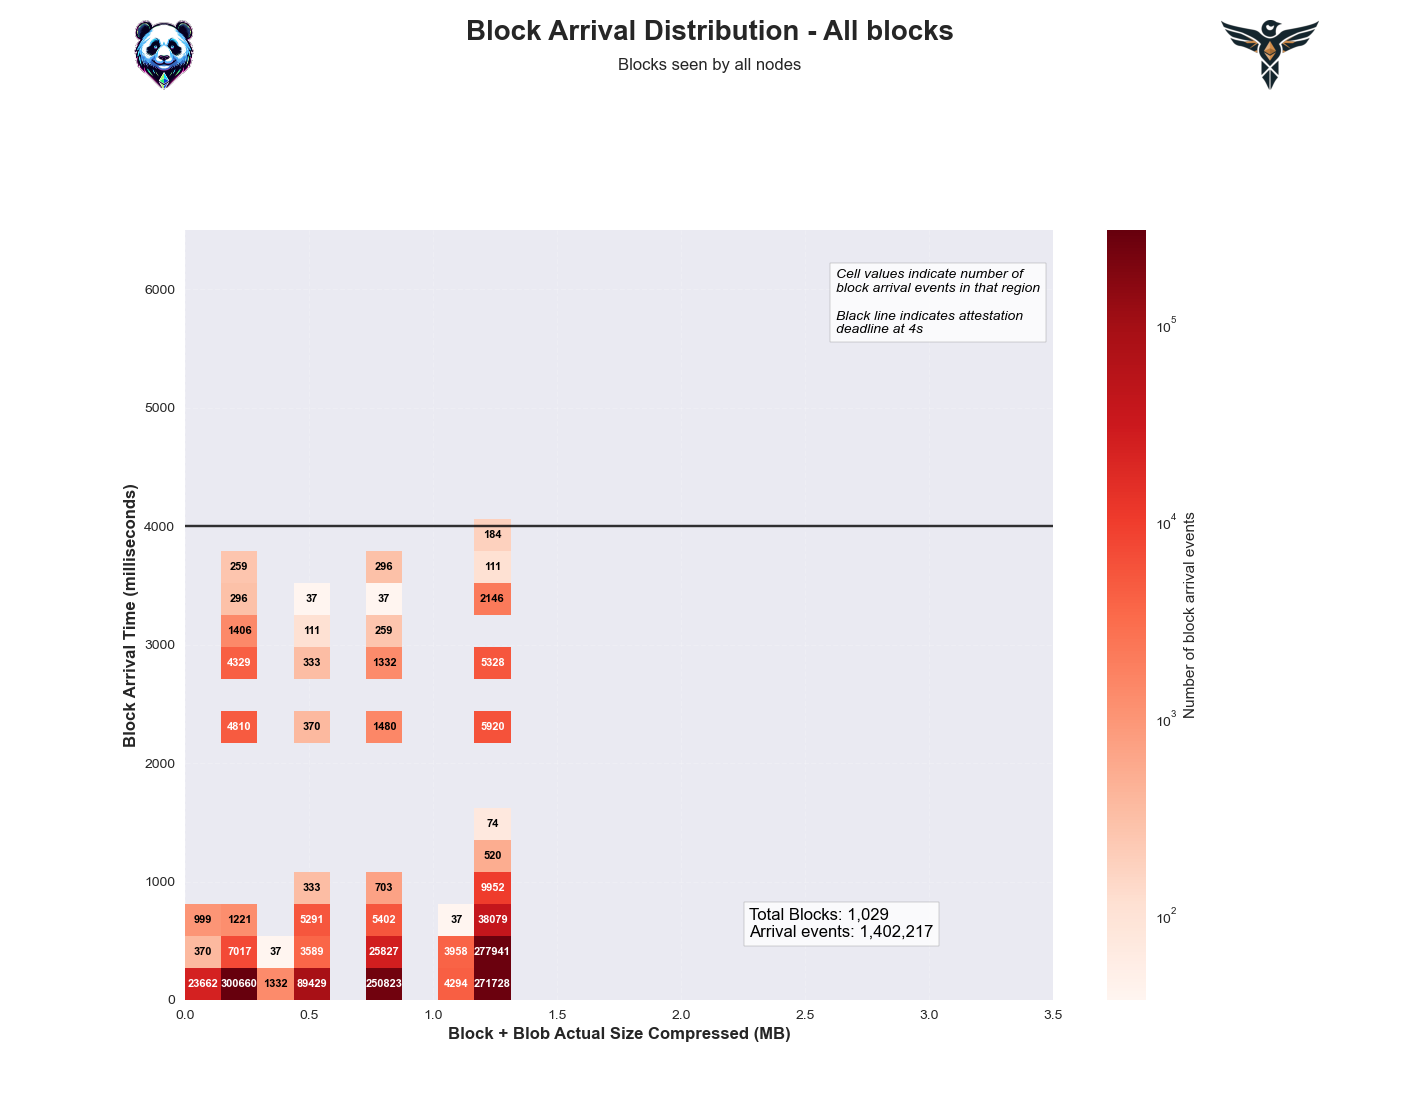

Creating plot for MEV: None Worst case with EIP7623 observed by all nodes


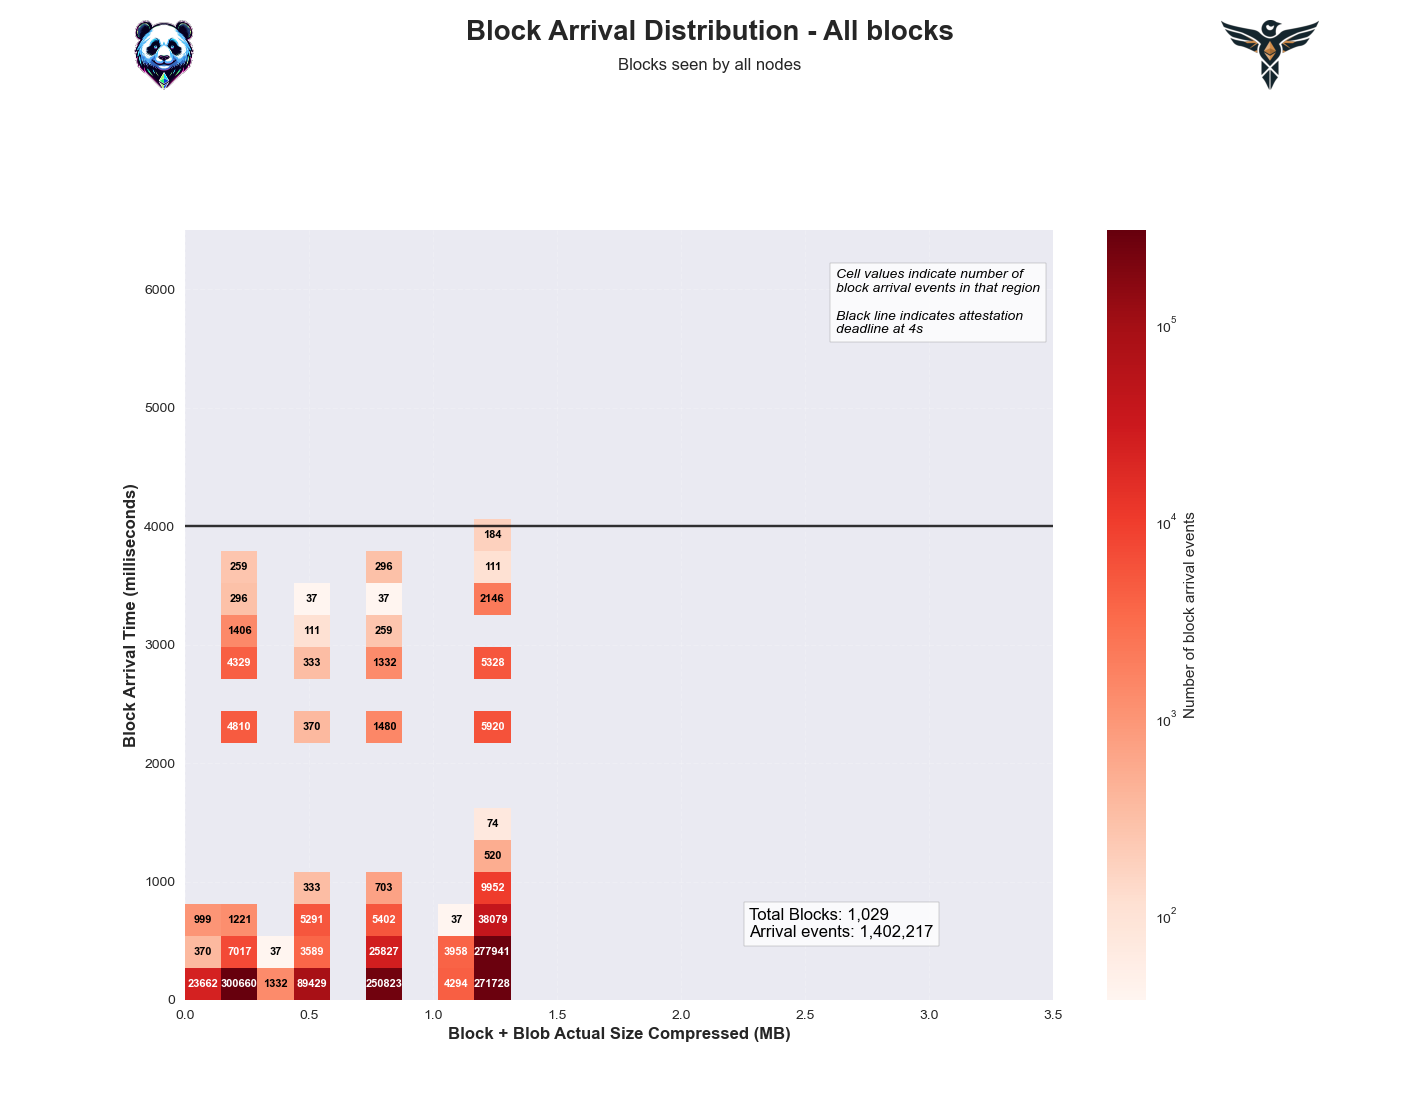

In [15]:
from matplotlib import gridspec, colors

# Define color map for title parameters
title_param_colors = {
    'mev_status': ['#2E86C1', '#E74C3C', '#27AE60'],  
    'entity_colors': ['#8E44AD', '#E67E22', '#16A085', '#2980B9', '#C0392B', '#7D3C98', '#F39C12', '#1ABC9C', '#2E86C1', '#E74C3C', '#27AE60', '#8E44AD', '#D35400', '#16A085', '#2980B9'],
    'observer_colors': ['#884EA0', '#D35400', '#1ABC9C']
}

observed_by_groups = ['all nodes']
figures = []
trend_data = []

feature_set = {'show_block_size': False, 'show_blob_count': True, 'show_trend_lines': False}

for block_size in block_sizes:
    for is_mev in [None]:
        for observed_by_group in observed_by_groups:
            if observed_by_group == 'nan':
                continue
            
            print(f"Creating plot for MEV: {is_mev} {block_size['label']} observed by {observed_by_group}")
            
            # Filter data based on conditions
            if is_mev is None:
                slots_df = combined_data
            # Merge and filter data
            plot_data = (arrival_data
                .merge(slots_df[['slot', 'block_total_bytes_compressed', 'total_blob_size']], on='slot'))
            
            if observed_by_group != 'all nodes':
                plot_data = plot_data.query(f"observed_by_group == '{observed_by_group}'")
            
            valid_mask = ~np.isnan(plot_data['arrival_time'])
            n_blocks = len(plot_data['slot'].unique())
            n_arrivals = np.sum(valid_mask)

            if n_blocks < 100:
                print(f"Skipping observed by {observed_by_group} (MEV: {is_mev}) due to low block count: {n_blocks}")
                continue

            if len(plot_data) == 0:
                print(f"No data observed by {observed_by_group}")
                continue

            # Calculate total size in MB
            plot_data['total_size_mb'] = (plot_data['block_total_bytes_compressed'] + plot_data['total_blob_size']) / 1_000_000

            # Create figure and gridspec
            plt.style.use('seaborn-v0_8')
            fig = plt.figure(figsize=(14, 10))
            
            # Calculate square bins based on axis limits
            x_max = 3.5  # MB
            y_max = 6500  # ms
            n_bins = 25  # Number of bins in each dimension
            
            x_bins = np.linspace(0, x_max, n_bins)
            y_bins = np.linspace(0, y_max, n_bins)
            
            heatmap, xedges, yedges = np.histogram2d(
                plot_data['total_size_mb'],
                plot_data['arrival_time'],
                bins=[x_bins, y_bins]
            )

            ax = fig.add_subplot(111)
            
            # Plot heatmap with white to red colormap
            im = ax.pcolormesh(xedges, yedges, heatmap.T, 
                             cmap='Reds', 
                             norm=colors.LogNorm())
            cbar = fig.colorbar(im, ax=ax, label='Number of block arrival events')

            # Add count text to each cell
            for i in range(len(x_bins)-1):
                for j in range(len(y_bins)-1):
                    if heatmap[i,j] > 0:  # Only show non-zero counts
                        ax.text(x_bins[i] + (x_bins[1]-x_bins[0])/2,
                              y_bins[j] + (y_bins[1]-y_bins[0])/2,
                              int(heatmap[i,j]),
                              ha='center', va='center',
                              color='white' if heatmap[i,j] > np.max(heatmap)/128 else 'black',
                              fontsize=8,
                              fontweight='bold')

            # Add attestation deadline line
            ax.axhline(y=4000, color='black', linestyle='-', alpha=0.8)

            mev_text = "MEV relay blocks" if is_mev else "Locally built blocks" if is_mev is not None else "All blocks"
            
            # Add legend for cell values and attestation deadline
            legend_text = ('Cell values indicate number of\nblock arrival events in that region\n\n'
                         'Black line indicates attestation\ndeadline at 4s')
            ax.text(0.75, 0.95, legend_text,
                    ha='left', va='top', transform=ax.transAxes,
                    fontsize=10, color='black', style='italic',
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

            # Add block and arrival counts
            ax.text(0.65, 0.12, f'Total Blocks: {n_blocks:,}\nArrival events: {n_arrivals:,}', 
                    ha='left', va='top', transform=ax.transAxes,
                    fontsize=12, color='black', 
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
            ax.set_xlabel('Block + Blob Actual Size Compressed (MB)', fontsize=12, fontweight='bold')
            ax.set_ylabel('Block Arrival Time (milliseconds)', fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.2, linestyle='--')
            ax.set_ylim(0, 6500)
            ax.set_xlim(0, 3.5)

            fig = add_branding(fig, title=f"Block Arrival Distribution - {mev_text}", subtitle=f"Blocks seen by {observed_by_group}")

            plt.show()
            plt.close()

Creating plot for MEV: None Historical p99 block size observed by all nodes


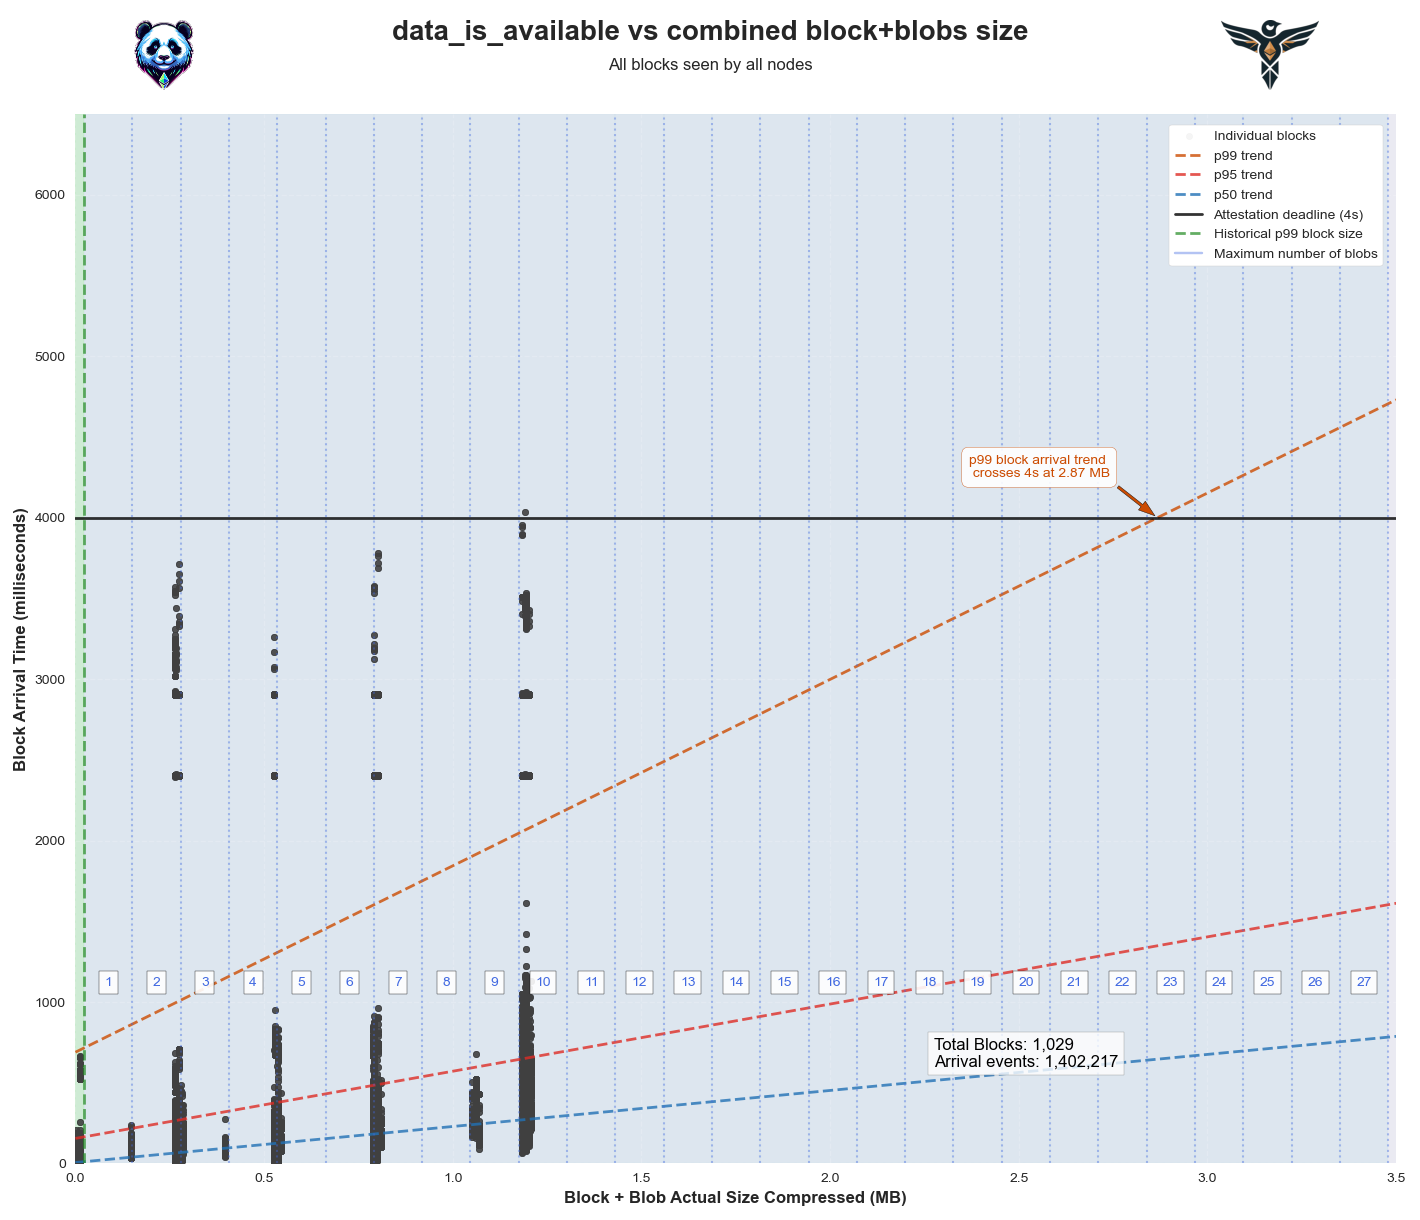

Creating plot for MEV: None Worst case with EIP7623 observed by all nodes


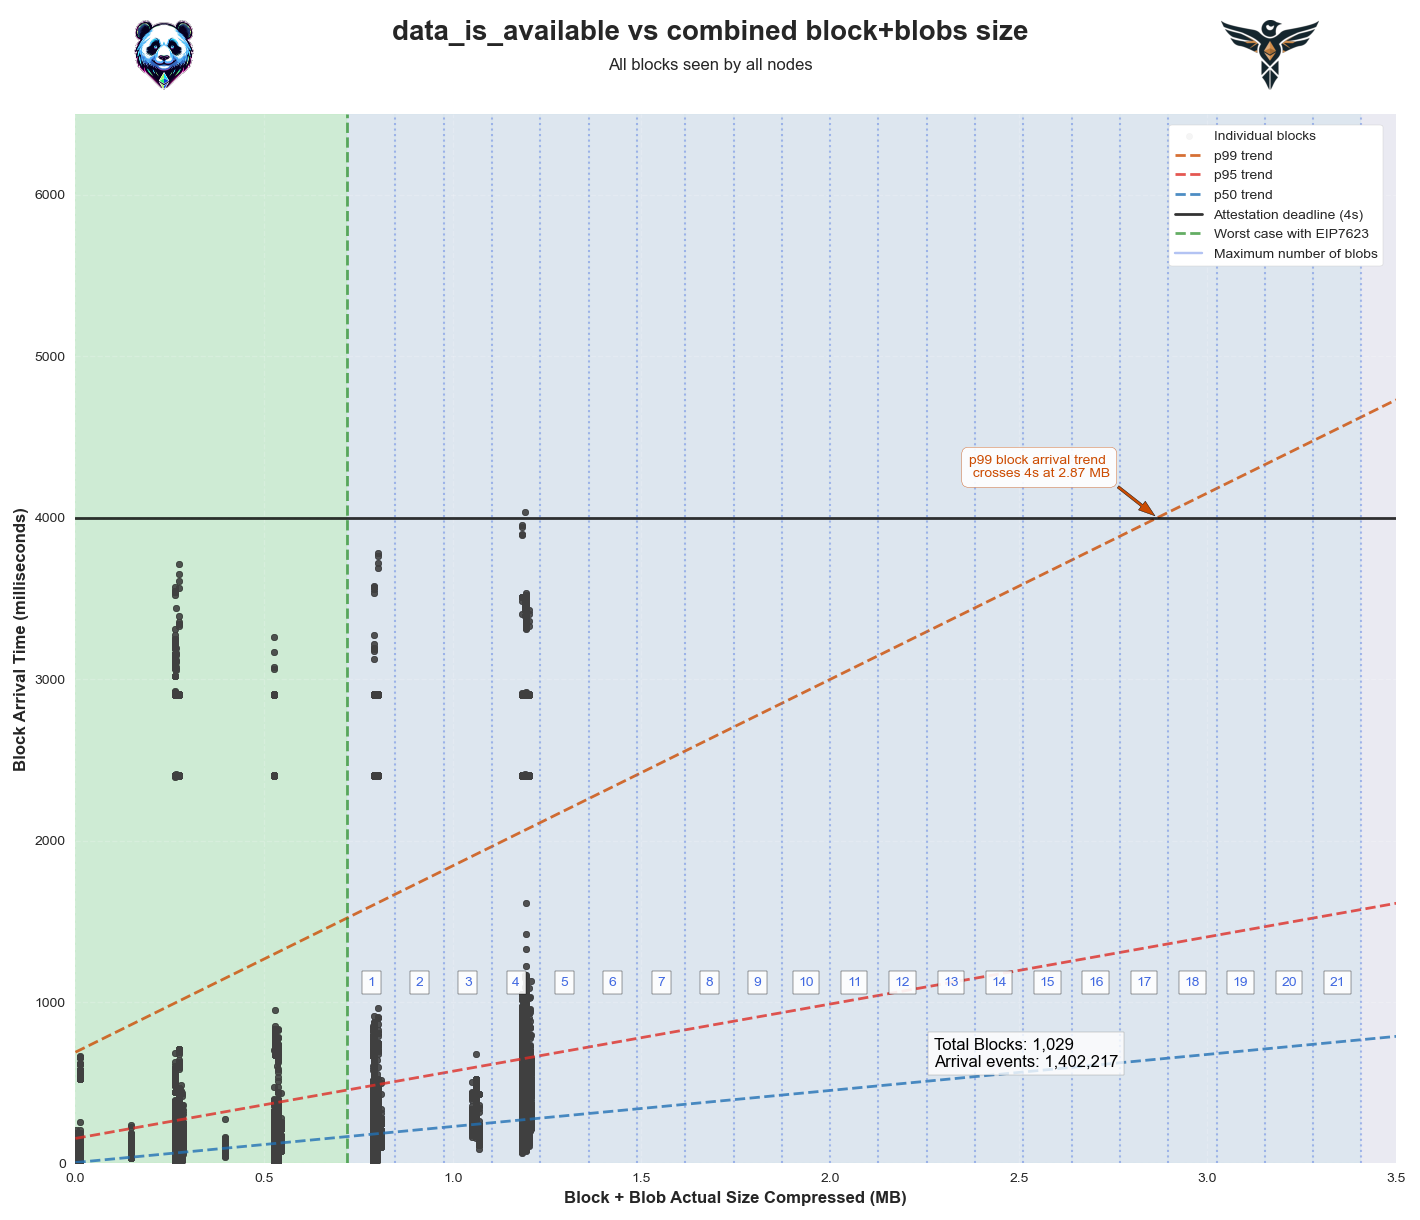

In [16]:
from matplotlib import gridspec

# Define color map for title parameters
title_param_colors = {
    'mev_status': ['#2E86C1', '#E74C3C', '#27AE60'],  
    'observer_colors': ['#884EA0', '#D35400', '#1ABC9C']
}

observed_by_groups = ['all nodes']
figures = []
trend_data = []

# Feature flags for gradual fade in
feature_sets = [
    {'show_block_size': True, 'show_blob_count': True, 'show_trend_lines': True}
]

for feature_set in feature_sets:
    for block_size in block_sizes:
        for is_mev in [None]:
            for observed_by_group in observed_by_groups:
                if observed_by_group == 'nan':
                    continue
                
                print(f"Creating plot for MEV: {is_mev} {block_size['label']} observed by {observed_by_group}")
                
                # Filter data based on conditions
                if is_mev is None:
                    slots_df = combined_data
                    
                # Merge and filter data
                plot_data = (arrival_data
                    .merge(slots_df[['slot', 'block_total_bytes_compressed', 'total_blob_size']], on='slot'))
                
                if observed_by_group != 'all nodes':
                    plot_data = plot_data.query(f"observed_by_group == '{observed_by_group}'")
                
                valid_mask = ~np.isnan(plot_data['arrival_time'])
                n_blocks = len(plot_data['slot'].unique())
                n_arrivals = np.sum(valid_mask)

                if n_blocks < 100:
                    print(f"Skipping observed by {observed_by_group} (MEV: {is_mev}) due to low block count: {n_blocks}")
                    continue

                if len(plot_data) == 0:
                    print(f"No data observed by {observed_by_group}")
                    continue

                # Calculate total size in MB
                plot_data['total_size_mb'] = (plot_data['block_total_bytes_compressed'] + plot_data['total_blob_size']) / 1_000_000

                # Create figure and gridspec
                plt.style.use('seaborn-v0_8')
                fig = plt.figure(figsize=(14, 11), constrained_layout=True)
                
                # Store metadata in figure for filename generation
                fig.metadata = {
                    'block_size': block_size['label'],
                    'is_mev': is_mev,
                    'observed_by': observed_by_group,
                    'features': '_'.join(k for k,v in feature_set.items() if v)
                }

                ax = fig.add_subplot(111)
                
                # Plot all points
                ax.scatter(plot_data['total_size_mb'], plot_data['arrival_time'], 
                          alpha=0.05, s=20, color='#404040', label='Individual blocks')

                # Add trend lines if enabled
                if feature_set['show_trend_lines'] and np.sum(valid_mask) > 1:
                    # Convert to numpy arrays and filter out NaN values
                    x_data = plot_data['total_size_mb'][valid_mask].values
                    y_data = plot_data['arrival_time'][valid_mask].values

                    # Calculate p99, p95 and p50 values per bin
                    bins = np.linspace(min(x_data), max(x_data), 20)
                    p99_vals = []
                    p95_vals = []
                    p50_vals = []
                    bin_centers = []
                    
                    for i in range(len(bins)-1):
                        mask = (x_data >= bins[i]) & (x_data < bins[i+1])
                        if np.sum(mask) > 0:
                            p99_vals.append(np.percentile(y_data[mask], 99))
                            p95_vals.append(np.percentile(y_data[mask], 95))
                            p50_vals.append(np.percentile(y_data[mask], 50))
                            bin_centers.append((bins[i] + bins[i+1])/2)

                    # Fit trend lines to percentile data
                    if len(bin_centers) > 1:
                        p99_z = np.polyfit(bin_centers, p99_vals, 1)
                        p95_z = np.polyfit(bin_centers, p95_vals, 1)
                        p50_z = np.polyfit(bin_centers, p50_vals, 1)

                        metrics = [
                            ('p99', p99_z, '#cc4c02'),
                            ('p95', p95_z, '#de2d26'), 
                            ('p50', p50_z, '#2171b5')
                        ]
                        x_range = np.linspace(0, 3.5, 100)

                        for label, z, color in metrics:
                            if z[0] > 0:
                                max_size = (4000 - z[1]) / z[0]
                                p_fit = np.poly1d(z)
                                
                                ax.plot(x_range, p_fit(x_range), '--', color=color, alpha=0.8, linewidth=2, label=f'{label} trend')
                                
                                if feature_set['show_blob_count']:
                                    if label == 'p95':
                                        offset = 3500
                                    else:
                                        offset = 4250
                                    ax.annotate(
                                        f'{label} block arrival trend\n crosses 4s at {max_size:.2f} MB',
                                        xy=(max_size, 4000),
                                        xytext=(max_size-0.5, offset),
                                        arrowprops=dict(facecolor=color, shrink=0.05, width=2, headwidth=8),
                                        color=color,
                                        fontsize=10,
                                        bbox=dict(facecolor='white', edgecolor=color, alpha=0.9, boxstyle='round,pad=0.5')
                                    )

                                base_size = block_size['value']
                                max_blobs = int((max_size - base_size) / 0.128)
                                trend_data.append({
                                    'is_mev': is_mev,
                                    'observed_by': observed_by_group,
                                    'metric': label,
                                    'max_size_mb': max_size,
                                    'max_blobs': max_blobs,
                                    'slope': z[0],
                                    'intercept': z[1]
                                })

                # Rest of plot formatting
                ax.axhline(y=4000, color='black', linestyle='-', alpha=0.8, linewidth=2, label='Attestation deadline (4s)')
                
                if feature_set['show_block_size']:
                    base_size = block_size['value']
                    ax.axvspan(0, base_size, color='#90EE90', alpha=0.3, zorder=0)
                    ax.axvline(x=base_size, color='#228B22', linestyle='--', alpha=0.7, linewidth=2, 
                              label=f"{block_size['label']}")

                if feature_set['show_blob_count']:
                    blob_increment = 0.128
                    for i in range(1, int((3.5 - base_size) / blob_increment) + 1):
                        x_pos = base_size + (i * blob_increment)
                        ax.axvspan(base_size + ((i-1) * blob_increment), x_pos, color='#ADD8E6', alpha=0.2, zorder=0)
                        ax.axvline(x=x_pos, color='#4169E1', linestyle=':', alpha=0.4, linewidth=1.5)
                        ax.text(x_pos - blob_increment/2, 1100,
                                str(i),
                                color='#4169E1',
                                alpha=1,
                                fontsize=10,
                                bbox=dict(facecolor='white', alpha=0.9),
                                ha='center')
                    ax.plot([], [], color='#4169E1', alpha=0.4, label='Maximum number of blobs')

                ax.legend(loc='upper right', frameon=True, framealpha=1.0, fontsize=10,
                         bbox_to_anchor=(0.99, 0.99), borderaxespad=0, facecolor='white')

                # Add block and arrival counts
                ax.text(0.65, 0.12, f'Total Blocks: {n_blocks:,}\nArrival events: {n_arrivals:,}', 
                        ha='left', va='top', transform=ax.transAxes,
                        fontsize=12, color='black', 
                        bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
                ax.set_xlabel('Block + Blob Actual Size Compressed (MB)', fontsize=12, fontweight='bold')
                ax.set_ylabel('Block Arrival Time (milliseconds)', fontsize=12, fontweight='bold')
                ax.grid(True, alpha=0.2, linestyle='--')
                ax.set_ylim(0000, 6500)
                ax.set_xlim(0, 3.5)

                mev_text = "MEV relay blocks" if is_mev else "Locally built blocks" if is_mev is not None else "All blocks"
                title = 'data_is_available vs combined block+blobs size' if feature_set['show_blob_count'] else 'Block Arrival Trend'
                subtitle = f"{mev_text} seen by {observed_by_group}"

                fig = add_branding(fig, title=title, subtitle=subtitle)

                if len(trend_data) > 0:
                    p99_data = [d for d in trend_data if d['metric'] == 'p99']
                    if p99_data:
                        figures.append((p99_data[-1]['max_size_mb'], fig))
                plt.show()
                plt.close()

figures.sort(key=lambda x: x[0], reverse=True)
trend_df = pd.DataFrame(trend_data)


In [18]:
fork_slot = fork_activation_epoch * 32
fork_group = arrival_data.groupby('slot_group').agg({'slot': ['min', 'max']})
fork_group.columns = ['min', 'max']
fork_group = fork_group.reset_index()
fork_group = fork_group[(fork_group['min'] <= fork_slot) & (fork_group['max'] >= fork_slot)]

fork_in_slot_range = fork_slot >= combined_data['slot'].min() and fork_slot <= combined_data['slot'].max()


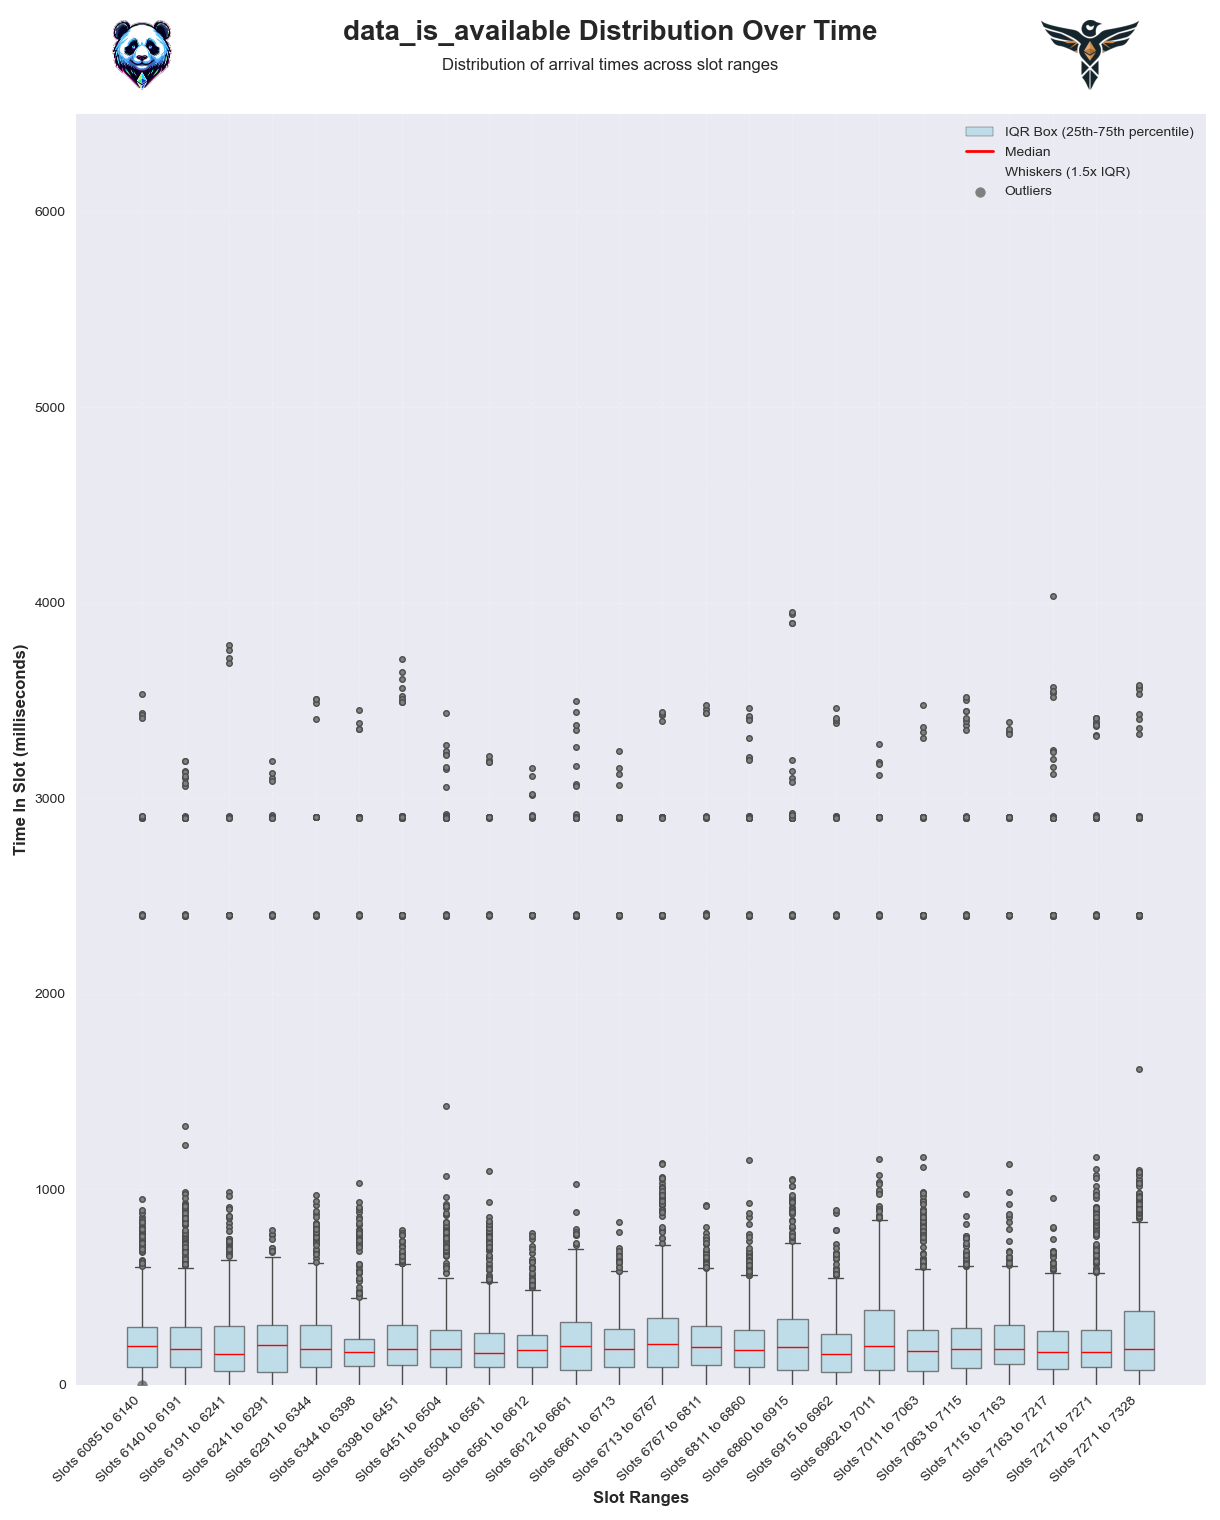

In [24]:
# Calculate slot ranges to create 24 evenly spaced groups
slot_min = arrival_data['slot'].min()
slot_max = arrival_data['slot'].max()
slot_range = slot_max - slot_min
slots_per_group = slot_range // 24

# Create the groups and labels with slot ranges
group_edges = pd.qcut(arrival_data['slot'], q=24, retbins=True)[1]
labels = [f'Slots {int(group_edges[i])} to {int(group_edges[i+1])}' for i in range(len(group_edges)-1)]

# Create new dataframe with slot groups
plot_data = arrival_data.copy()
plot_data['slot_group'] = pd.qcut(plot_data['slot'], q=24, labels=labels)

# Create box plot
plt.figure(figsize=(12, 14), constrained_layout=True)
sns.boxplot(data=plot_data, x='slot_group', y='arrival_time', width=0.7,
            medianprops={"color": "red"},
            flierprops={"marker": "o", "markerfacecolor": "gray", "markersize": 4},
            boxprops={"facecolor": "lightblue", "alpha": 0.7})

# Add legend explaining box plot elements
handles = [
    plt.Rectangle((0,0),1,1, facecolor='lightblue', alpha=0.7, ec='black'),
    plt.Line2D([0], [0], color='red', linestyle='-', linewidth=2),
    plt.Line2D([0], [0], color='black', marker='_', linestyle='None', markersize=10),
    plt.scatter([0], [0], color='gray', marker='o', s=50)
]
labels = [
    'IQR Box (25th-75th percentile)',
    'Median', 
    'Whiskers (1.5x IQR)',
    'Outliers'
]
plt.legend(handles, labels, loc='upper right', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.xlabel('Slot Ranges', fontsize=12, fontweight='bold')
plt.ylabel('Time In Slot (milliseconds)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.2, linestyle='--')
plt.ylim(0, 6500)

if not fork_group.empty:
    fork_line_x = plot_data['slot_group'].unique().tolist().index(fork_group['slot_group'].iloc[0])
    plt.axvline(x=fork_line_x, color='red', linestyle='--', alpha=0.5, linewidth=2)
    plt.text(fork_line_x + 0.2, 6000, 'Fork', rotation=90, color='red', alpha=0.8,
             fontsize=12, fontweight='bold')

fig = plt.gcf()
fig = add_branding(fig, title='data_is_available Distribution Over Time',
                  subtitle='Distribution of arrival times across slot ranges')

plt.show()
plt.close()


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_36275/2562170112.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = plot_data.groupby('slot_group')['arrival_time'].agg([
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_36275/2562170112.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fork_index = plot_data.groupby('slot_group').apply(lambda x: fork_slot >= x['slot'].min() and fork_slot <= x['slot'].max()).reset_index()
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_36275/2562170112.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns.

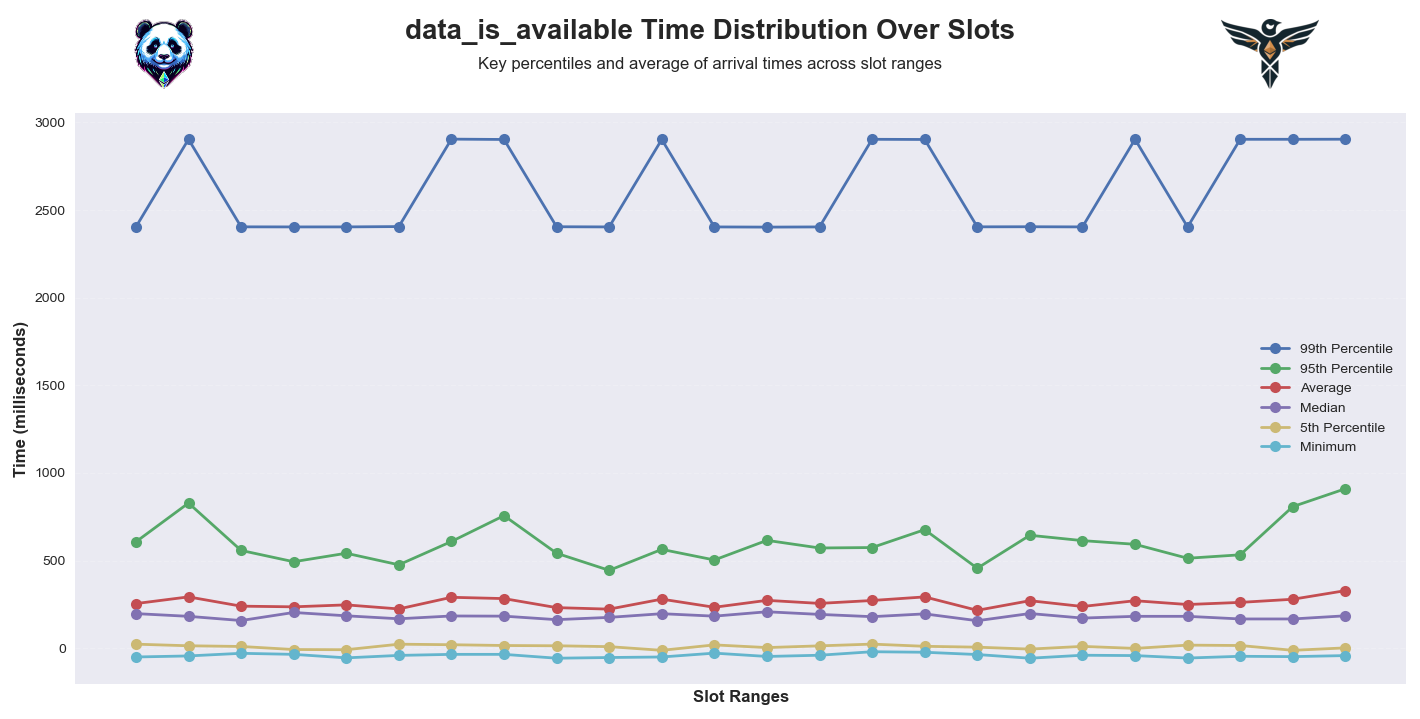

In [27]:
# Calculate percentiles and average for each slot group
plot_data = arrival_data.copy()

# Generate labels for slot groups
slot_labels = [f'Group {i+1}' for i in range(24)]
plot_data['slot_group'] = pd.qcut(plot_data['slot'], q=24, labels=slot_labels)

stats = plot_data.groupby('slot_group')['arrival_time'].agg([
    ('min', 'min'),
    ('p05', lambda x: x.quantile(0.05)), 
    ('p50', 'median'),
    ('avg', 'mean'),
    ('p95', lambda x: x.quantile(0.95)),
    ('p99', lambda x: x.quantile(0.99))
]).reset_index()

plt.figure(figsize=(14, 6), constrained_layout=True)

plt.plot(range(len(stats)), stats['p99'], marker='o', linewidth=2, markersize=8, label='99th Percentile')
plt.plot(range(len(stats)), stats['p95'], marker='o', linewidth=2, markersize=8, label='95th Percentile')
plt.plot(range(len(stats)), stats['avg'], marker='o', linewidth=2, markersize=8, label='Average')
plt.plot(range(len(stats)), stats['p50'], marker='o', linewidth=2, markersize=8, label='Median')
plt.plot(range(len(stats)), stats['p05'], marker='o', linewidth=2, markersize=8, label='5th Percentile')
plt.plot(range(len(stats)), stats['min'], marker='o', linewidth=2, markersize=8, label='Minimum')

plt.xticks([])
plt.xlabel('Slot Ranges', fontsize=12, fontweight='bold')
plt.ylabel('Time (milliseconds)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.2, linestyle='--')
plt.legend(fontsize=10)

# Find the index of the slot group containing the fork slot
if fork_in_slot_range:
    fork_slot = fork_activation_epoch * 32
    fork_index = plot_data.groupby('slot_group').apply(lambda x: fork_slot >= x['slot'].min() and fork_slot <= x['slot'].max()).reset_index()
    fork_matches = fork_index[fork_index[0]]
    if not fork_matches.empty:
        fork_line_x = fork_matches.index[0]
        # Add fork time annotation
        plt.axvline(x=fork_line_x, color='red', linestyle='--', alpha=0.5, linewidth=2)
        plt.text(fork_line_x + 0.2, stats['p99'].max() * 0.9, 'Fork', rotation=90, color='red', alpha=0.8,
                fontsize=12, fontweight='bold')

fig = plt.gcf()
fig = add_branding(fig, title='data_is_available Time Distribution Over Slots',
                  subtitle='Key percentiles and average of arrival times across slot ranges')

plt.show()
plt.close()


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_36275/2709634906.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  event_counts = plot_data.groupby('slot_group')['meta_client_name'].nunique()
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_36275/2709634906.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fork_index = plot_data.groupby('slot_group').apply(lambda x: fork_slot >= x['slot'].min() and fork_slot <= x['slot'].max()).reset_index()
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_36275/2709634906.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the gr

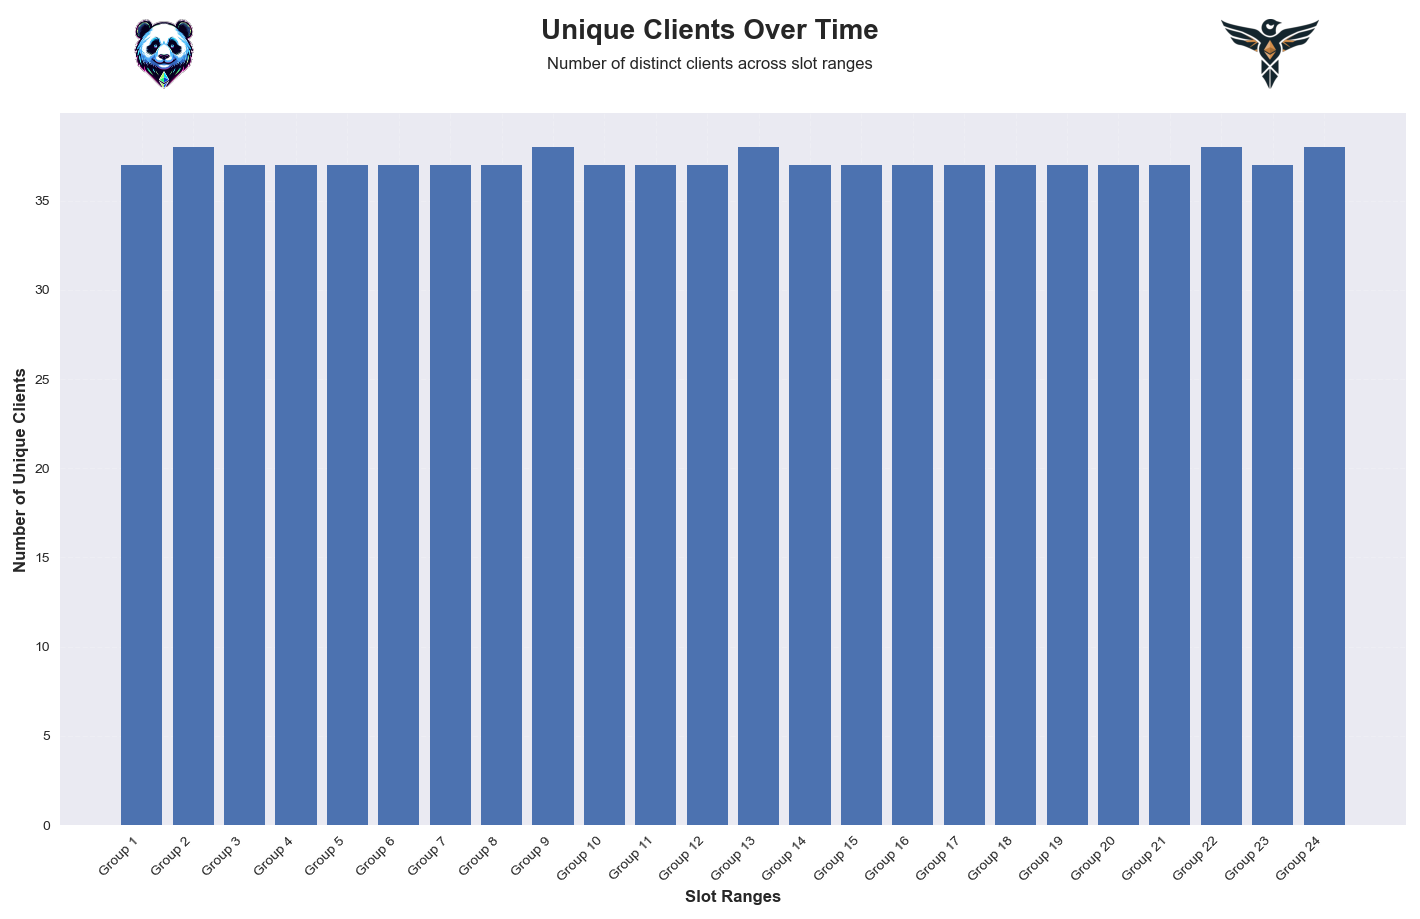

In [29]:
# Group by slot_group and count distinct clients
slot_labels = [f'Group {i+1}' for i in range(24)]
plot_data['slot_group'] = pd.qcut(plot_data['slot'], q=24, labels=slot_labels)
event_counts = plot_data.groupby('slot_group')['meta_client_name'].nunique()

plt.figure(figsize=(14, 8), constrained_layout=True)

plt.bar(range(len(event_counts)), event_counts, width=0.8)

plt.xticks(range(len(event_counts)), event_counts.index, rotation=45, ha='right')
plt.xlabel('Slot Ranges', fontsize=12, fontweight='bold')
plt.ylabel('Number of Unique Clients', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.2, linestyle='--')

if fork_in_slot_range:
    fork_slot = fork_activation_epoch * 32
    fork_index = plot_data.groupby('slot_group').apply(lambda x: fork_slot >= x['slot'].min() and fork_slot <= x['slot'].max()).reset_index()
    fork_matches = fork_index[fork_index[0]]
    if not fork_matches.empty:
        fork_line_x = fork_matches.index[0]
        plt.axvline(x=fork_line_x, color='red', linestyle='--', alpha=0.5, linewidth=2)
        plt.text(fork_line_x + 0.2, event_counts.max() * 0.9, 'Fork', rotation=90, color='red',
                alpha=0.8, fontsize=12, fontweight='bold')

fig = plt.gcf()
fig = add_branding(fig, title='Unique Clients Over Time',
                  subtitle='Number of distinct clients across slot ranges')

plt.tight_layout()
plt.show()
plt.close()


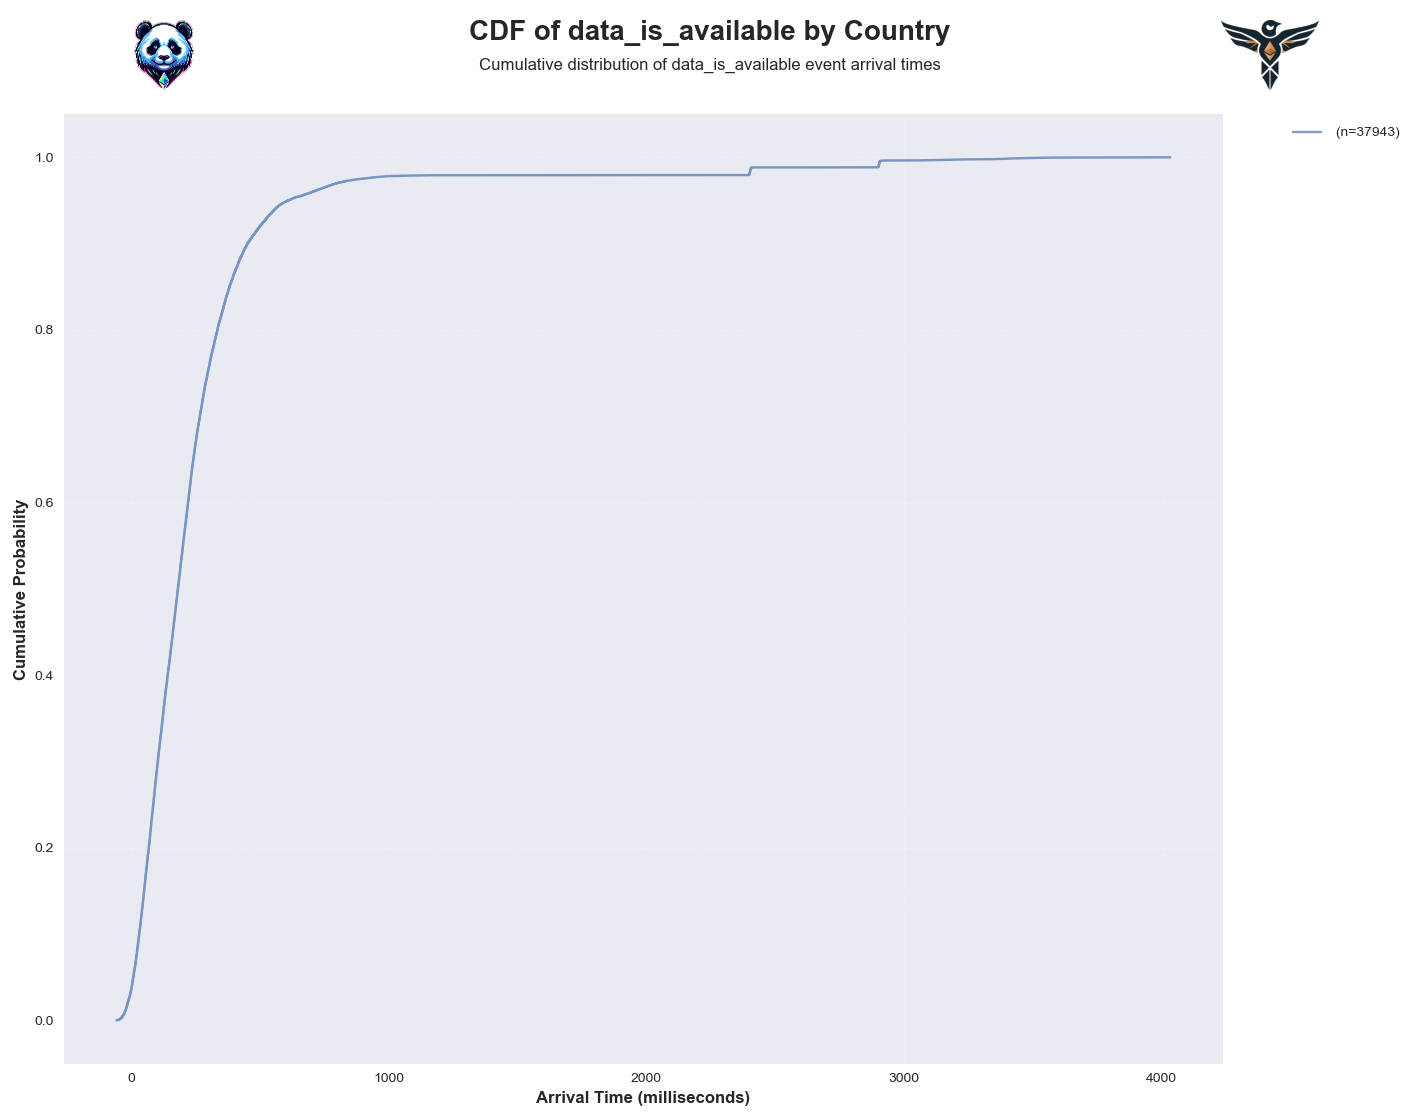

In [33]:
# Calculate CDF per country
country_data = arrival_data.groupby('country')['arrival_time'].apply(list).to_dict()

plt.figure(figsize=(14, 10), constrained_layout=True)

for country, times in country_data.items():
    if len(times) > 100:  # Only plot countries with sufficient data points
        times_sorted = np.sort(times)
        cumulative_prob = np.arange(1, len(times_sorted) + 1) / len(times_sorted)
        plt.plot(times_sorted, cumulative_prob, label=f'{country} (n={len(times)})', alpha=0.7)

plt.xlabel('Arrival Time (milliseconds)', fontsize=12, fontweight='bold')
plt.ylabel('Cumulative Probability', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.2, linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

fig = plt.gcf()
fig = add_branding(fig, title='CDF of data_is_available by Country',
                  subtitle='Cumulative distribution of data_is_available event arrival times')

plt.show()
plt.close()


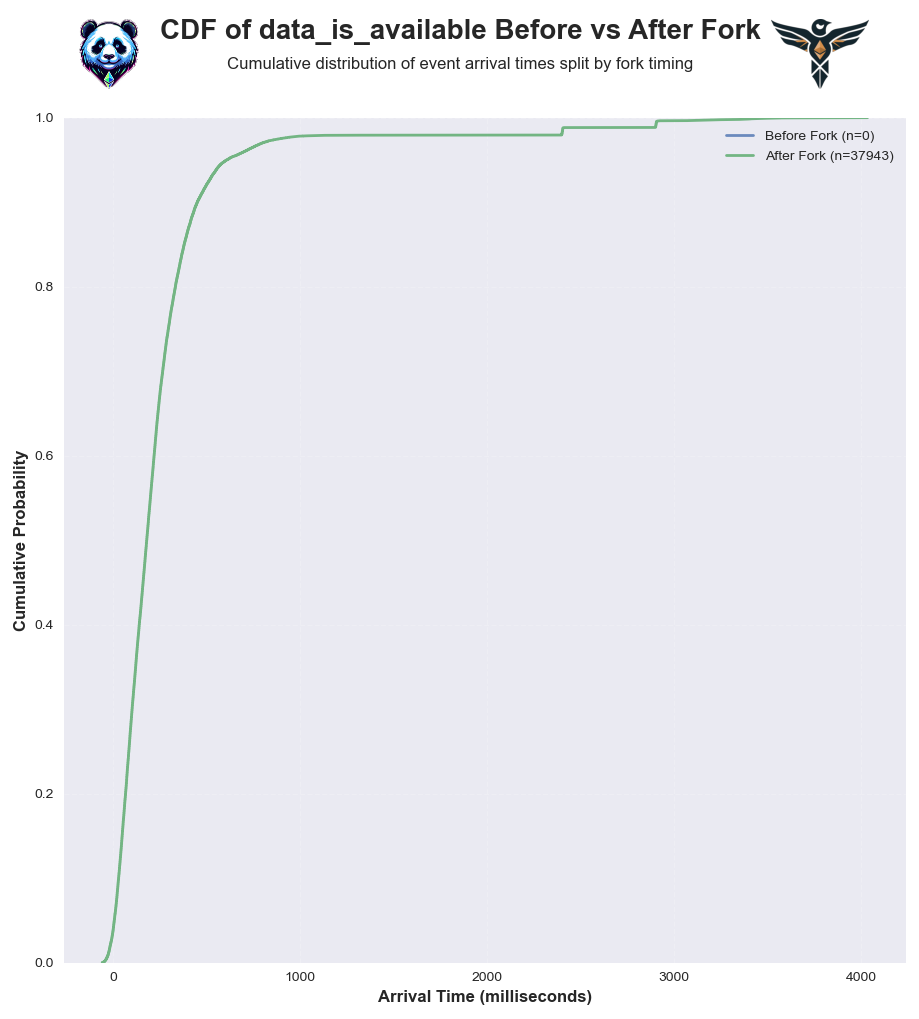

In [32]:
# Calculate CDF before/after fork
fork_slot = fork_activation_epoch * 32
before_fork = arrival_data[arrival_data['slot'] < fork_slot]['arrival_time']
after_fork = arrival_data[arrival_data['slot'] >= fork_slot]['arrival_time']

plt.figure(figsize=(9, 9), constrained_layout=True)

# Plot CDFs
for data, label in [(before_fork, 'Before Fork'), (after_fork, 'After Fork')]:
    times_sorted = np.sort(data)
    cumulative_prob = np.arange(1, len(times_sorted) + 1) / len(times_sorted)
    plt.plot(times_sorted, cumulative_prob, 
            label=f'{label} (n={len(data)})', 
            alpha=0.8,
            linewidth=2)

plt.xlabel('Arrival Time (milliseconds)', fontsize=12, fontweight='bold')
plt.ylabel('Cumulative Probability', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.2, linestyle='--')
plt.legend(fontsize=10)
plt.ylim(0.0, 1.0)  # Show from 0% to 100% for better detail

fig = plt.gcf()
fig = add_branding(fig, title='CDF of data_is_available Before vs After Fork',
                  subtitle='Cumulative distribution of event arrival times split by fork timing')

plt.show()
plt.close()


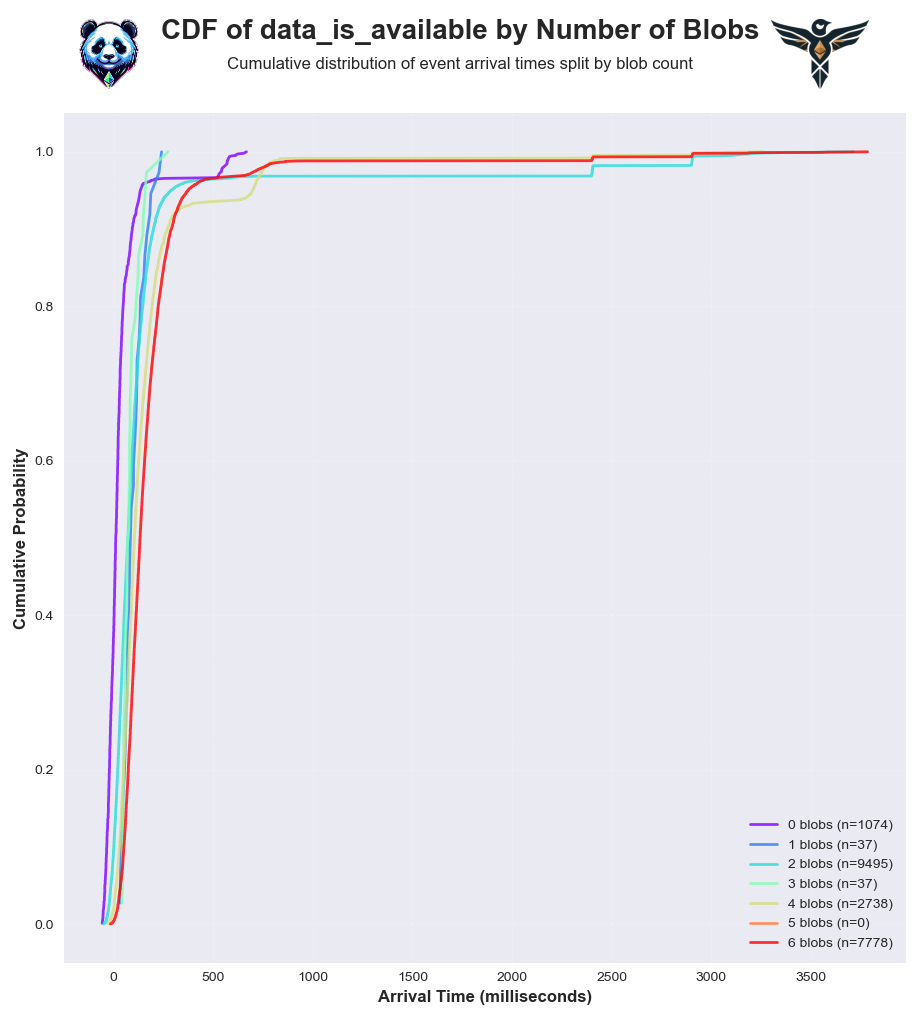

In [34]:
# Calculate CDF by number of blobs
plt.figure(figsize=(9, 9), constrained_layout=True)

colors = plt.cm.rainbow(np.linspace(0, 1, len(combined_data['num_blobs'].unique())))
sorted_blobs = sorted(combined_data['num_blobs'].unique())

for num_blobs, color in zip(sorted_blobs, colors):
    data = arrival_data[arrival_data['slot'].isin(combined_data[combined_data['num_blobs'] == num_blobs]['slot'])]['arrival_time']
    times_sorted = np.sort(data)
    cumulative_prob = np.arange(1, len(times_sorted) + 1) / len(times_sorted)
    plt.plot(times_sorted, cumulative_prob,
             label=f'{num_blobs} blobs (n={len(data)})',
             alpha=0.8,
             linewidth=2,
             color=color)

plt.xlabel('Arrival Time (milliseconds)', fontsize=12, fontweight='bold')
plt.ylabel('Cumulative Probability', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.2, linestyle='--')
plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

fig = plt.gcf()
fig = add_branding(fig, title='CDF of data_is_available by Number of Blobs',
                  subtitle='Cumulative distribution of event arrival times split by blob count')

plt.show()
plt.close()
